In [4]:
import pandas as pd

from enum import Enum

class Frontend(Enum):
    Cold = 0
    Warm = 1

def to_path(f):
    match f:
        case Frontend.Cold: return "cold/"
        case Frontend.Warm: return "warm/"


warm = "warm/"
cold = "cold/"
warm_performance_json = warm + "performances.json"
cold_performance_json = cold + "performances.json"
warm_commands_json = warm + "commands.json"
cold_commands_json = cold + "commands.json"
warm_logs_json = warm + "logs.json"
cold_logs_json = cold + "logs.json"
warm_metadata_json = warm + "metadata.json"
cold_metadata_json = cold + "metadata.json"

def merlin_responses(fr):
    fr_path = to_path(fr)
    return fr_path + "query_responses.json"

merlin_responses(Frontend.Cold)

'cold/query_responses.json'

## The merlin cache

Let's have a look whether the cache seems to have been inited correctly during the warm run.

_Explanation_: we've run each `merlin` query on each sample 10 times with the idea to analyze variance. When using the merlin frontend Server (cli-option `warm`), `merl-an` should initialize the `merlin` cache on each file before running the queries.

In [6]:
warm_performance = pd.read_json("warm/performances.json", lines = True)
cold_performance = pd.read_json(cold_performance_json, lines = True)
cold_performance_truncated = cold_performance[["sample_id", "timings", "max_timing"]]
cold_performance_truncated = cold_performance_truncated.rename(columns={"timings" : "cold_timings", "max_timing" : "cold_max_timing"})
performance = pd.merge(warm_performance, cold_performance_truncated, on = "sample_id")
performance = performance.sort_values("max_timing", ascending = False)[["sample_id", "timings", "max_timing", "cold_timings", "cold_max_timing", "query_type", "file"]]

### Observation

On one hand, there're quite a few samples with the following pattern: on `warm`, the first of the 10 queries takes way longer than the other 9. However, the the same queries in `cold` mode take even considerably longer.

This seems to be the case particularly often in the samples that have taken the longest (on `warm).

In [7]:
n = 5
# TODO (note for myself): turns out that it's a horrible idea to store a list inside a pandas series.
# If I want to keep on using pandas, I need to change the layout of the data files.
init_cache_suspicous = performance.copy()
init_cache_suspicous["timings"] = init_cache_suspicous["timings"].apply(lambda ts: ts if ts[0] == max(ts) else None)
init_cache_suspicous=init_cache_suspicous.dropna()
init_cache_suspicous = init_cache_suspicous[init_cache_suspicous["max_timing"] < init_cache_suspicous["cold_max_timing"]]
init_cache_suspicous.sort_values("max_timing", ascending = False).iloc[:n, :]


,sample_id,timings,max_timing,cold_timings,cold_max_timing,query_type,file
209,30,"[3665, 111, 126, 123, 123, 124, 123, 124, 123,...",3665,"[8050, 8157, 8138, 7979, 7974, 7943, 8030, 793...",8157,[Type_enclosing],app/rfq-reports/reports/trading/lib/bond_singl...
239,0,"[3662, 100, 107, 104, 107, 108, 106, 103, 106,...",3662,"[5774, 5096, 5063, 4643, 4580, 4641, 4694, 461...",5774,[Locate],app/rfq-reports/reports/trading/lib/bond_singl...
216,23,"[961, 106, 101, 129, 106, 105, 102, 104, 103, ...",961,"[7799, 5048, 4659, 4634, 4665, 4636, 4600, 460...",7799,[Locate],app/rfq-reports/reports/trading/lib/bond_singl...
235,4,"[502, 102, 121, 116, 118, 115, 116, 116, 116, ...",502,"[4773, 4739, 4737, 4742, 4779, 4743, 4785, 480...",4807,[Locate],app/rfq-reports/reports/trading/lib/bond_singl...
59,180,"[495, 79, 81, 92, 99, 92, 99, 90, 100, 90]",495,"[639, 608, 595, 593, 593, 595, 593, 587, 588, ...",639,[Locate],lib/async_unix/src/writer0.ml


On the other hand, there are also quite a few queries, on which it isn't the case that the first repeat was the one that took the longest:

In [8]:
n = 5
init_cache_seems_fine = performance.copy()
init_cache_seems_fine["timings"] = init_cache_seems_fine["timings"].apply(lambda ts: None if ts[0] == max(ts) else ts).dropna()
init_cache_seems_fine = init_cache_seems_fine.dropna().sort_values("max_timing", ascending = False)
init_cache_seems_fine.sort_values("max_timing", ascending = False).iloc[:n, :]

,sample_id,timings,max_timing,cold_timings,cold_max_timing,query_type,file
37,202,"[97, 174, 82, 146, 78, 79, 78, 79, 3369, 91]",3369,"[596, 597, 606, 599, 601, 599, 610, 611, 652, ...",652,[Locate],lib/async_unix/src/writer0.ml
219,20,"[116, 117, 117, 116, 100, 117, 113, 123, 122, ...",175,"[4607, 4563, 4574, 4538, 4556, 4548, 4578, 460...",4621,[Locate],app/rfq-reports/reports/trading/lib/bond_singl...
220,19,"[120, 120, 120, 136, 120, 120, 119, 119, 117, ...",136,"[4808, 4755, 4720, 5112, 5329, 4869, 4769, 472...",5329,[Locate],app/rfq-reports/reports/trading/lib/bond_singl...
175,64,"[55, 57, 135, 57, 70, 75, 56, 65, 57, 56]",135,"[576, 575, 572, 575, 572, 577, 574, 577, 578, ...",578,[Locate],lib/core_unix/src/core_unix.ml
38,201,"[86, 83, 78, 87, 76, 134, 80, 82, 75, 82]",134,"[599, 614, 597, 596, 597, 599, 594, 593, 599, ...",614,[Locate],lib/async_unix/src/writer0.ml


What's the ratio between the two scenerios?

In [9]:
len(init_cache_suspicous)

74

In [10]:
len(init_cache_seems_fine)

166

I guess I'm doing something wrong with the cache initialization... (also, btw, the "init cache suspicious"-scenario happens far more often when the timing is poor)

## Variance

Let's filter out the samples in which the cache initialization seems to have been suspicious when visualizing the variance.

<AxesSubplot: >

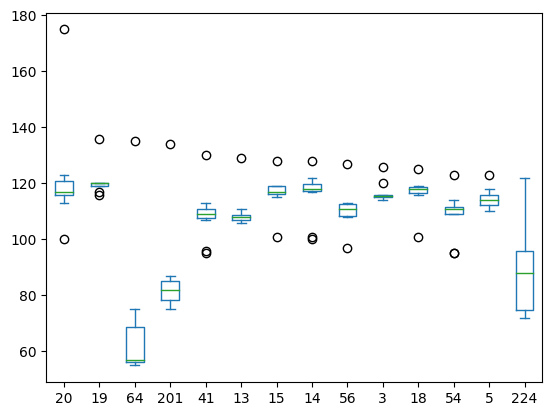

In [11]:
timings_per_query = pd.DataFrame({row["sample_id"] : row["timings"] for i, row in init_cache_seems_fine.iterrows()})
worst_timings = timings_per_query.iloc[:, 1:15]
worst_timings.plot.box()

In [12]:
import numpy as np

worst_file = "app/rfq-reports/reports/trading/lib/bond_single_rfq.ml"
data = cold_performance[cold_performance["file"] == worst_file]
# cold_performance
data
# data["variance"] = data.apply(lambda d: d["timings"])
# data = data.sort_values("variance", ascending=False)

# timings_per_query = pd.DataFrame({row["sample_id"] : row["timings"] for i, row in data.iterrows()})
# worst_timings = timings_per_query.iloc[:, 1:15]
# worst_timings.plot.box()

,sample_id,timings,max_timing,file,query_type,loc
180,59,"[8002, 7942, 8022, 7946, 7999, 7953, 8013, 797...",8022,app/rfq-reports/reports/trading/lib/bond_singl...,[Type_enclosing],"File ""app/rfq-reports/reports/trading/lib/bond..."
181,58,"[7964, 7955, 7941, 7927, 7921, 7958, 7922, 796...",7993,app/rfq-reports/reports/trading/lib/bond_singl...,[Type_enclosing],"File ""app/rfq-reports/reports/trading/lib/bond..."
182,57,"[5213, 5187, 5224, 5220, 5211, 5211, 5231, 524...",5244,app/rfq-reports/reports/trading/lib/bond_singl...,[Type_enclosing],"File ""app/rfq-reports/reports/trading/lib/bond..."
183,56,"[7942, 7918, 7932, 7944, 7867, 7826, 7811, 788...",7944,app/rfq-reports/reports/trading/lib/bond_singl...,[Type_enclosing],"File ""app/rfq-reports/reports/trading/lib/bond..."
184,55,"[6271, 6285, 6298, 6347, 6303, 6306, 6296, 629...",6347,app/rfq-reports/reports/trading/lib/bond_singl...,[Type_enclosing],"File ""app/rfq-reports/reports/trading/lib/bond..."
185,54,"[6210, 6202, 6154, 6210, 6194, 6196, 6190, 617...",6210,app/rfq-reports/reports/trading/lib/bond_singl...,[Type_enclosing],"File ""app/rfq-reports/reports/trading/lib/bond..."
186,53,"[7984, 7918, 7987, 7962, 7956, 7996, 7992, 796...",7996,app/rfq-reports/reports/trading/lib/bond_singl...,[Type_enclosing],"File ""app/rfq-reports/reports/trading/lib/bond..."
187,52,"[7149, 7176, 7133, 7168, 7163, 7177, 7183, 717...",7183,app/rfq-reports/reports/trading/lib/bond_singl...,[Type_enclosing],"File ""app/rfq-reports/reports/trading/lib/bond..."
188,51,"[7986, 8018, 7992, 7995, 8020, 8052, 8019, 798...",8052,app/rfq-reports/reports/trading/lib/bond_singl...,[Type_enclosing],"File ""app/rfq-reports/reports/trading/lib/bond..."
189,50,"[8001, 8002, 7983, 8002, 8027, 7982, 7997, 807...",8074,app/rfq-reports/reports/trading/lib/bond_singl...,[Type_enclosing],"File ""app/rfq-reports/reports/trading/lib/bond..."


##  Analyze timing info in merlin reply

In [83]:
def plot(data_taken_into_account, frontend, timing_section, query_type = None, truncate_on = None):
        # Small hack: Need to fix query_type type: for some reason it gets serialized into a list
    data_taken_into_account["query_type"] = data_taken_into_account["query_type"].apply(lambda qt: qt[0] if isinstance(qt, list) else qt )
    data = data_taken_into_account.copy() if query_type == None else data_taken_into_account.copy()[data_taken_into_account["query_type"] == query_type]
    merlin_responses_json = merlin_responses(frontend)
    mr = pd.read_json(merlin_responses_json, lines = True)
    all = pd.merge(data, mr, on = "sample_id")
    graph = pd.DataFrame.from_records([{"time": reply["timing"]["clock"], timing_section : reply["timing"][timing_section]} for i, row in all.iterrows() for reply in row["responses"]])
    graph = graph[graph["time"] < truncate_on] if truncate_on != None else graph
    graph.plot.scatter(x="time", y=timing_section, title=query_type)

In [84]:
pd.read_json(merlin_responses(Frontend.Warm), lines=True)["responses"][0][0]["timing"]

{'clock': 75,
 'cpu': 74,
 'query': 4,
 'pp': 0,
 'reader': 10,
 'ppx': 56,
 'typer': 4,
 'error': 0}

## Current time/space trade-off

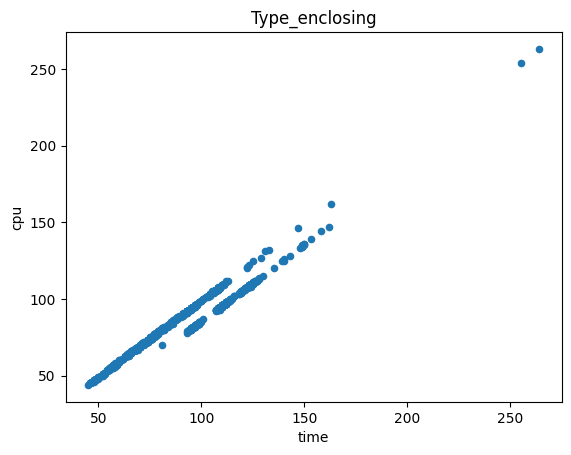

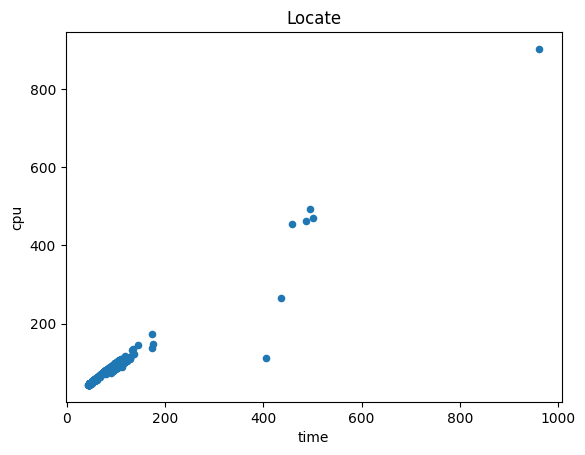

In [85]:
plot(performance, Frontend.Warm, "cpu", query_type = "Type_enclosing", truncate_on=3000)
plot(performance, Frontend.Warm,"cpu", query_type = "Locate", truncate_on=3000)

## Type checker

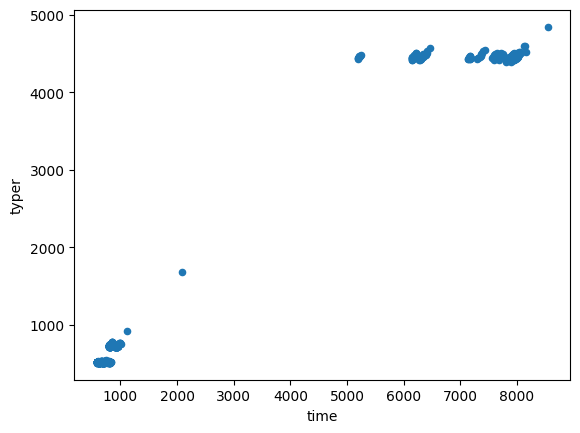

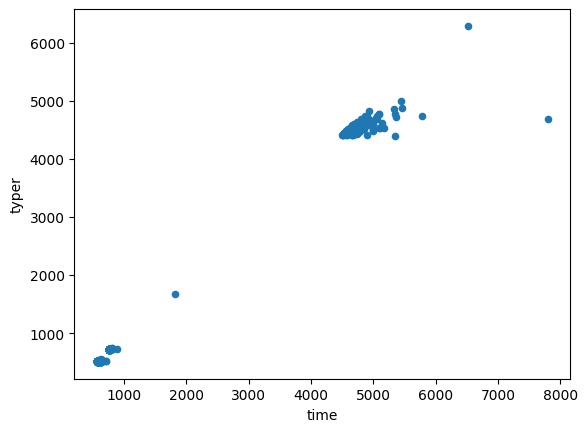

In [ ]:
plot(cold_performance, Frontend.Cold, "typer", "Type_enclosing")
plot(cold_performance, Frontend.Cold, "typer", "Locate")


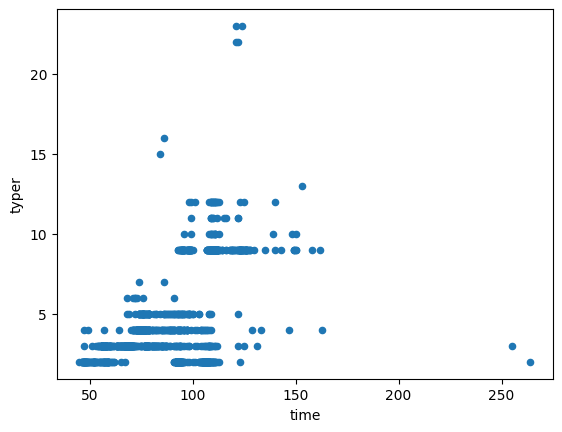

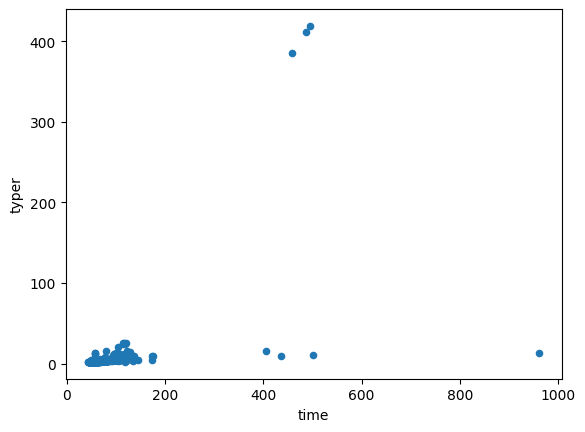

In [ ]:
plot(performance, Frontend.Warm, "typer", query_type = "Type_enclosing", truncate_on=3000)
plot(performance, Frontend.Warm,"typer", query_type = "Locate", truncate_on=3000)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

population = np.random.rand(100)
Area = np.random.randint(100,600,100)
continent =['North America','Europe', 'Asia', 'Australia']*25

df = pd.DataFrame(dict(population=population, Area=Area, continent = continent))
df

,population,Area,continent
0,0.015230,367,North America
1,0.238078,368,Europe
2,0.985976,318,Asia
3,0.027672,195,Australia
4,0.195527,468,North America
...,...,...,...
95,0.235438,110,Australia
96,0.394706,452,North America
97,0.749714,434,Europe
98,0.557426,310,Asia


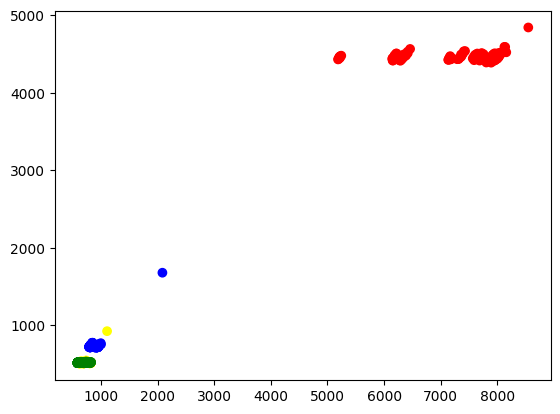

In [ ]:
# plot(performance, Frontend.Warm, "typer", query_type = "Type_enclosing", truncate_on=3000)
# plot(performance, Frontend.Warm,"typer", query_type = "Locate", truncate_on=3000)

[row["file"] for i, row in performance.iterrows()]

import matplotlib.pyplot as plt
from matplotlib import colors as mcolors


colors = ["red", "green", "blue", "yellow"]+ list(mcolors.CSS4_COLORS.keys())
files = [*set([row["file"] for i, row in performance.iterrows()])]
colors_dict = {file : colors[i] for i, file in enumerate(files)}


data_taken_into_account = cold_performance
frontend = Frontend.Warm
timing_section = "typer"
query_type = "Type_enclosing"
truncate_on=3000

    # Small hack: Need to fix query_type type: for some reason it gets serialized into a list
data_taken_into_account["query_type"] = data_taken_into_account["query_type"].apply(lambda qt: qt[0] if isinstance(qt, list) else qt )
data = data_taken_into_account.copy() if query_type == None else data_taken_into_account.copy()[data_taken_into_account["query_type"] == query_type]
merlin_responses_json = merlin_responses(frontend)
mr = pd.read_json(merlin_responses_json, lines = True)
all = pd.merge(data, mr, on = "sample_id")
graph = pd.DataFrame.from_records([{"time": reply["timing"]["clock"], timing_section : reply["timing"][timing_section], "file" : row["file"]} for i, row in all.iterrows() for reply in row["responses"]])
graph = graph[graph["time"] < truncate_on] if truncate_on != None else graph


fig, ax = plt.subplots()
ax.scatter(graph["time"], graph[timing_section], c=graph["file"].map(colors_dict))
# graph.sort_values("time", ascending=False)



In [ ]:
# cold_performance

/tmp/ipykernel_312656/581328573.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_taken_into_account["query_type"] = data_taken_into_account["query_type"].apply(lambda qt: qt[0] if isinstance(qt, list) else qt )


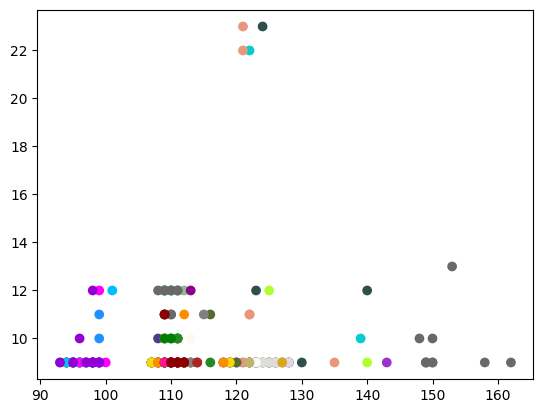

In [26]:
# plot(performance, Frontend.Warm, "typer", query_type = "Type_enclosing", truncate_on=3000)
# plot(performance, Frontend.Warm,"typer", query_type = "Locate", truncate_on=3000)

worst_file = "app/rfq-reports/reports/trading/lib/bond_single_rfq.ml"

import matplotlib.pyplot as plt
from matplotlib import colors as mcolors


data_taken_into_account = performance[performance["file"] == worst_file]
frontend = Frontend.Warm
timing_section = "typer"
query_type = "Type_enclosing"
truncate_on=3000

colors = ["red", "green", "blue", "yellow"]+ list(mcolors.CSS4_COLORS.keys())
files = [*set([row["sample_id"] for i, row in data_taken_into_account.iterrows()])]
colors_dict = {file : colors[i] for i, file in enumerate(files)}

# Small hack: Need to fix query_type type: for some reason it gets serialized into a list
data_taken_into_account["query_type"] = data_taken_into_account["query_type"].apply(lambda qt: qt[0] if isinstance(qt, list) else qt )
data = data_taken_into_account.copy() if query_type == None else data_taken_into_account.copy()[data_taken_into_account["query_type"] == query_type]
merlin_responses_json = merlin_responses(frontend)
mr = pd.read_json(merlin_responses_json, lines = True)
all = pd.merge(data, mr, on = "sample_id")
graph = pd.DataFrame.from_records([{"time": reply["timing"]["clock"], timing_section : reply["timing"][timing_section], "sample_id" : row["sample_id"]} for i, row in all.iterrows() for reply in row["responses"]])
graph = graph[graph["time"] < truncate_on] if truncate_on != None else graph


fig, ax = plt.subplots()
ax.scatter(graph["time"], graph[timing_section], c=graph["sample_id"].map(colors_dict))



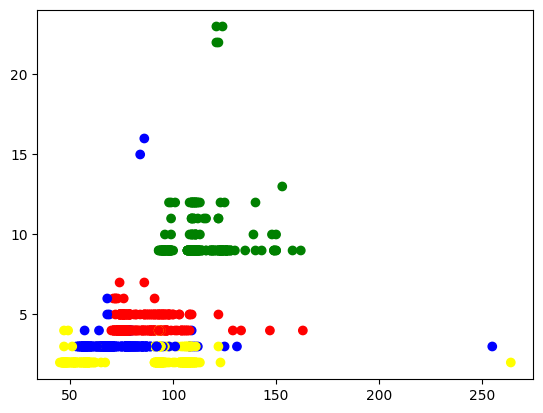

In [23]:
# plot(performance, Frontend.Warm, "typer", query_type = "Type_enclosing", truncate_on=3000)
# plot(performance, Frontend.Warm,"typer", query_type = "Locate", truncate_on=3000)

worst_file = "app/rfq-reports/reports/trading/lib/bond_single_rfq.ml"

import matplotlib.pyplot as plt
from matplotlib import colors as mcolors


data_taken_into_account = performance
frontend = Frontend.Warm
timing_section = "typer"
query_type = "Type_enclosing"
truncate_on=3000

colors = ["red", "green", "blue", "yellow"]+ list(mcolors.CSS4_COLORS.keys())
files = [*set([row["file"] for i, row in data_taken_into_account.iterrows()])]
colors_dict = {file : colors[i] for i, file in enumerate(files)}

# Small hack: Need to fix query_type type: for some reason it gets serialized into a list
data_taken_into_account["query_type"] = data_taken_into_account["query_type"].apply(lambda qt: qt[0] if isinstance(qt, list) else qt )
data = data_taken_into_account.copy() if query_type == None else data_taken_into_account.copy()[data_taken_into_account["query_type"] == query_type]
merlin_responses_json = merlin_responses(frontend)
mr = pd.read_json(merlin_responses_json, lines = True)
all = pd.merge(data, mr, on = "sample_id")
graph = pd.DataFrame.from_records([{"time": reply["timing"]["clock"], timing_section : reply["timing"][timing_section], "file" : row["file"]} for i, row in all.iterrows() for reply in row["responses"]])
graph = graph[graph["time"] < truncate_on] if truncate_on != None else graph


fig, ax = plt.subplots()
ax.scatter(graph["time"], graph[timing_section], c=graph["file"].map(colors_dict))
# graph



In [ ]:
colors = list(mcolors.CSS4_COLORS.keys())


## Reader

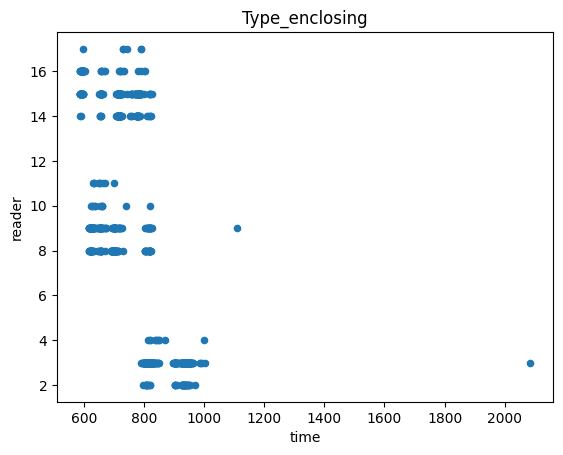

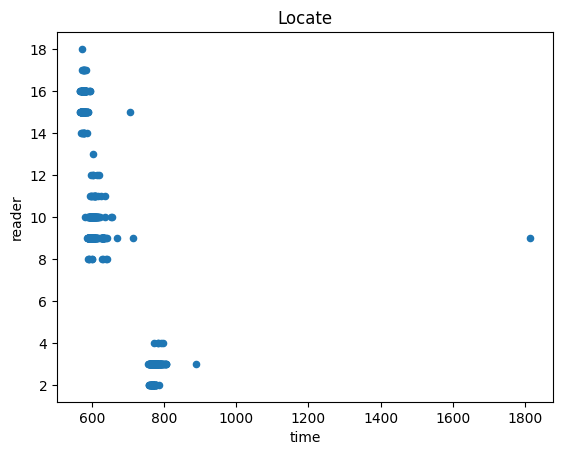

In [16]:
plot(cold_performance, Frontend.Cold, "reader", query_type = "Type_enclosing", truncate_on=3000)
plot(cold_performance, Frontend.Cold,"reader", query_type = "Locate", truncate_on=3000)

## PPX

## Samples that have one repeat that's "off"

In [72]:
performance[performance["max_timing"] > 3000]

,sample_id,timings,max_timing,cold_timings,cold_max_timing,query_type,file
209,30,"[3665, 111, 126, 123, 123, 124, 123, 124, 123,...",3665,"[8050, 8157, 8138, 7979, 7974, 7943, 8030, 793...",8157,Type_enclosing,app/rfq-reports/reports/trading/lib/bond_singl...
239,0,"[3662, 100, 107, 104, 107, 108, 106, 103, 106,...",3662,"[5774, 5096, 5063, 4643, 4580, 4641, 4694, 461...",5774,Locate,app/rfq-reports/reports/trading/lib/bond_singl...
37,202,"[97, 174, 82, 146, 78, 79, 78, 79, 3369, 91]",3369,"[596, 597, 606, 599, 601, 599, 610, 611, 652, ...",652,Locate,lib/async_unix/src/writer0.ml


In [82]:
merlin_responses_json = merlin_responses(Frontend.Warm)
mr = pd.read_json(merlin_responses_json, lines = True)
mr = pd.merge(mr, performance, on="sample_id")
mr = mr[mr["sample_id"].isin([0,30,202])]


outstanding_samples = pd.DataFrame.from_records([({"sample_id": row["sample_id"], "repeat" : i,  "query_type" : row["query_type"]} | reply["timing"]) for i, row in mr.iterrows() for i, reply in enumerate(row["responses"])])
cols = outstanding_samples.columns.to_list()
reordered_cols = cols[0:2] + cols[3:] + [cols[2]]
outstanding_samples = outstanding_samples[reordered_cols]
# outstanding_samples.style.apply(lambda x: ["background: red" if v > 3000 else "" for v in x], axis = 1)
outstanding_samples.style.apply(lambda x: ["background: red" if isinstance(v, int) and v > 3000 else "" for v in x], axis = 1)

# outstanding_samples


,sample_id,repeat,clock,cpu,query,pp,reader,ppx,typer,error,query_type
0,202,0,97,96,18,0,13,60,5,0,Locate
1,202,1,174,173,14,0,94,61,5,0,Locate
2,202,2,82,81,3,0,13,60,5,0,Locate
3,202,3,146,145,5,0,77,60,5,0,Locate
4,202,4,78,77,3,0,8,62,5,0,Locate
5,202,5,79,78,1,0,10,59,8,0,Locate
6,202,6,78,77,1,0,11,60,5,0,Locate
7,202,7,79,78,5,0,9,60,5,0,Locate
8,202,8,3369,3357,4,0,3289,60,4,0,Locate
9,202,9,91,90,1,0,27,57,5,0,Locate
